# Settings

In [45]:
from pathlib import Path

import numpy as np
from scipy import stats as sp_stats
import pandas as pd
pd.plotting.register_matplotlib_converters()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

In [46]:
sb.set(rc={'figure.figsize':(20, 6)})
sb.set_theme(style="whitegrid", palette="pastel")

In [47]:
syntanic_data_path = Path(r'.\data\train.csv')
syntanic_data = pd.read_csv(syntanic_data_path, index_col='PassengerId')
ports_of_embarkation = ['Southampton', 'Cherbourg', 'Queenstown']
syntanic_data['Embarked'].replace(
      {p[0]: p for p in ports_of_embarkation},
      inplace=True)

syntanic_data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,Southampton
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,Southampton
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,Southampton
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,Southampton
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,Southampton
5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,Southampton
6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,Southampton
7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,Southampton
8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,Southampton


# Context

Здесь использован синтетический набор данных основанный на реальных данных с Титаника.

В данных следующие колонки: ``` ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] ```, а ```'PassengerId'``` использован как индекс строки.

#### Data dictionary:
```'PassengerId'``` -- ID пассажира
```Survived``` -- показывает, выжил ли пассажир или нет (1 -- Yes, 0 -- No)
```Pclass``` -- класс пассажира (1 -- 1 класс (наивысший), 2 -- средний, 3 -- низкий (эконом?))
```Name``` -- имя пассажира (формат: ИМЯ, ФАМИЛИЯ)
```Sex``` -- пол пассажира
```Age``` -- возраст пассажира
```SibSp``` (<b>Sib</b>ling, <b>Sp</b>ouse) -- количество братьев и сестер на корабле или наличие мужа или жены на корабле
```Parch``` (<b>Par</b>ent, <b>Ch</b>ild) -- количество родителей или детей на корабле
```Ticket``` -- номер билета
```Fare``` -- стоимость тарифа
```Cabin``` -- номер каюты
```Embarked``` -- Порт назначения (C -- Cherbourg, Q -- Queenstown, S -- Southampton)

#### Впоследствии добавленные признаки:
```Relatives``` -- количество родственников на корабле
```CabinPrefix``` -- префикс номера каюты
```AgeGroup``` -- возрастная группа


##### Примечание:
Значения в признаке ```Embarked``` заменены полными значениями.

В ходе изучения данных выдвинуто предположение, что основной целью является выявление степени влияния различных параметров на вероятность выживания пассажира. Однако это не отбрасывает интерес к зависимостям между другими параметрами

# Data quality assessment

In [48]:
par_total_rows = syntanic_data.shape[0]
par_total_cols = syntanic_data.shape[1]
par_dtypes_dict = {}
for col_name in syntanic_data:
      par_dtypes_dict[col_name] = syntanic_data[col_name].dtype.name

print('Количество строк (пассажиров) в данных {:d}, '
      'количество колонок - {:d}. '
      'В каждой из колонок данные следующих типов:\n{}\n'
      'При импорте сокращенные названия портов назначения '
      'были заменены на полные. Однако правдивость данных '
      'в представленных колонках следует исследовать отдельно '
      '(например нахождение всех родственников по фамилии)'
      .format(par_total_rows, par_total_cols, '\n'.join(
      f'\'{k}\' - {v}' for k, v in par_dtypes_dict.items())))

Количество строк (пассажиров) в данных 100000, количество колонок - 11. В каждой из колонок данные следующих типов:
'Survived' - int64
'Pclass' - int64
'Name' - object
'Sex' - object
'Age' - float64
'SibSp' - int64
'Parch' - int64
'Ticket' - object
'Fare' - float64
'Cabin' - object
'Embarked' - object
При импорте сокращенные названия портов назначения были заменены на полные. Однако правдивость данных в представленных колонках следует исследовать отдельно (например нахождение всех родственников по фамилии)


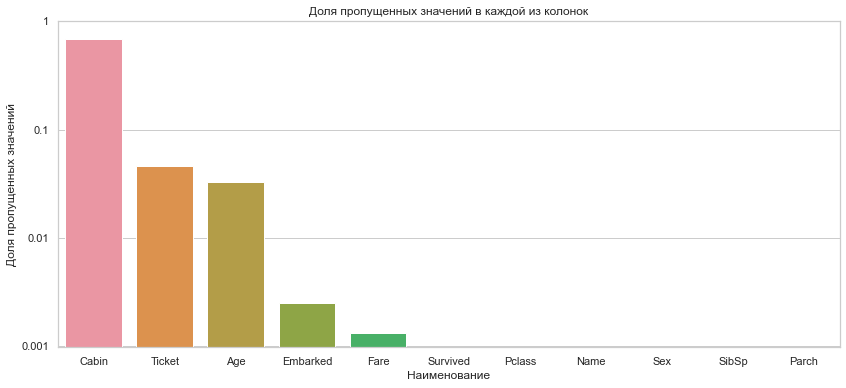

Среди колонок наибольшее количество пропущенных значений имеет номер кабины ('Cabin' = 67.87%), далее номер билета ('Ticket' = 4.62%) и возраст ('Age' = 3.29%), а наименьшее - порт назначения ('Embarked' = 0.25%) и тариф ('Fare' = 0.13%). В остальных колонках нет пропущенных значений.
При этом во всем датасете обнаружено 0 полностью пустых строк


In [49]:
plt.figure(figsize=(14, 6))
plt.title('Доля пропущенных значений в каждой из колонок')

na_fraction = (syntanic_data.isna().sum() / par_total_rows).sort_values(ascending=False)
na_frac_fig = sb.barplot(x=na_fraction.index, y=na_fraction)
na_frac_fig.set(xlabel='Наименование', ylabel='Доля пропущенных значений')
na_frac_fig.set_yscale("log")
na_frac_fig.set_yticks([0.001, 0.01, 0.1, 1])
na_frac_fig.set_yticklabels([0.001, 0.01, 0.1, 1])
plt.show()

print('Среди колонок наибольшее количество пропущенных значений имеет '
      'номер кабины (\'Cabin\' = {:.2%}), далее номер билета '
      '(\'Ticket\' = {:.2%}) и возраст (\'Age\' = {:.2%}), '
      'а наименьшее - порт назначения (\'Embarked\' = {:.2%}) '
      'и тариф (\'Fare\' = {:.2%}). В остальных колонках '
      'нет пропущенных значений.'\
      .format(na_fraction['Cabin'], na_fraction['Ticket'], na_fraction['Age'],
              na_fraction['Embarked'], na_fraction['Fare']))
print('При этом во всем датасете обнаружено {:d} полностью пустых строк'
      .format(par_total_rows - syntanic_data.dropna(how='all').shape[0]))

Датасет имеет 0 строк-дубликатов


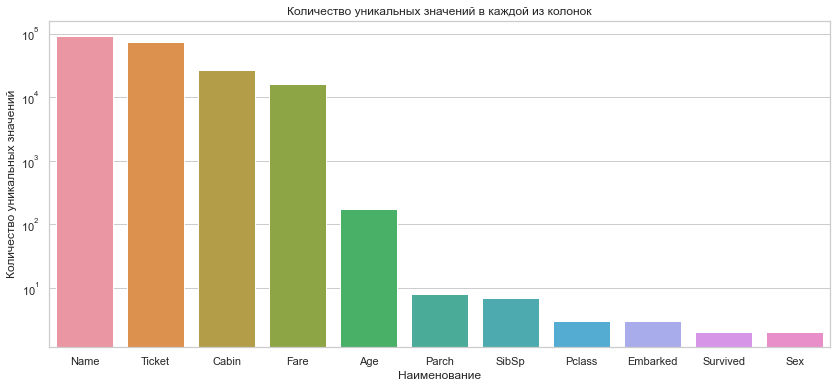

При расчете отсутвующие значения отбрасывались. Среди данных уникальных имен 92144, номеров билетов 75331 (самый часто встречающийся билет - 'A/5 ' (601 раз)), номеров кают 26992 (что логично, так как каюты бывают многоместные и также в этих данных больше всего отсутствующих значений)


In [50]:
print('Датасет имеет {:d} строк-дубликатов'\
      .format(syntanic_data[syntanic_data.duplicated()].shape[0]))

plt.figure(figsize=(14, 6))
plt.title('Количество уникальных значений в каждой из колонок')

unique_values_count = syntanic_data.nunique(dropna=True).sort_values(ascending=False)
unique_vals_fig = sb.barplot(x=unique_values_count.index, y=unique_values_count)
unique_vals_fig.set(xlabel='Наименование', ylabel='Количество уникальных значений')
unique_vals_fig.set_yscale('log')
plt.show()

duplicated_tickets = syntanic_data['Ticket'].dropna()[syntanic_data['Ticket']\
      .dropna().duplicated()].value_counts()

print('При расчете отсутвующие значения отбрасывались. '
      'Среди данных уникальных имен {:d}, номеров билетов {:d} '
      '(самый часто встречающийся билет - \'{}\' ({:d} раз)), '
      'номеров кают {:d} (что логично, так как каюты бывают '
      'многоместные и также в этих данных больше всего '
      'отсутствующих значений)'\
      .format(unique_values_count['Name'], unique_values_count['Ticket'],
              duplicated_tickets.idxmax(), duplicated_tickets.max(),
              unique_values_count['Cabin']))

Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается предположение, что в этом поле много невалидных данных.

In [51]:
par_outliner_col_names = ['Age', 'SibSp', 'Parch', 'Fare']
par_outliners_dict = {}
for col_name in par_outliner_col_names:
      par_outliners_dict[col_name] = syntanic_data[
            (sp_stats.zscore(syntanic_data[col_name]) > 3) & (syntanic_data[col_name] != 0)].shape[0]

print('В колонках {} обнаружены следующее кол-во выбросов '
      '(выброс определялся по z-score > 3)\n{}\n'
      'Так как многие из пассажиров находились на корабле '
      'без родственников, то при рассчете z-score они не учитывались.\n'
      'Максимальные значения для \'SibSp\' - 2, \'Parch\' - 3 ('
      'без выбросов). Так как предполагается, что количество '
      'родственников носит случайный характер, то полученные '
      'результаты не будут учитываться и будет считаться, '
      'что в данных отсутствуют выбросы.'
      .format(
      ', '.join(par_outliner_col_names),
      '\n'.join(f'\'{k}\' - {v}' for k, v
                in par_outliners_dict.items())))

В колонках Age, SibSp, Parch, Fare обнаружены следующее кол-во выбросов (выброс определялся по z-score > 3)
'Age' - 0
'SibSp' - 3231
'Parch' - 1245
'Fare' - 0
Так как многие из пассажиров находились на корабле без родственников, то при рассчете z-score они не учитывались.
Максимальные значения для 'SibSp' - 2, 'Parch' - 3 (без выбросов). Так как предполагается, что количество родственников носит случайный характер, то полученные результаты не будут учитываться и будет считаться, что в данных отсутствуют выбросы.


Заполним недостающие данные в колонках ```'Age', 'Fare'``` -- медианой, ```'Embarked'``` -- модой

In [52]:
def get_age_group(age: int):
      groups = ['0-16', '17-20', '21-30', '31-40', '41-50',
                '51-60', '61-70', '71-80', '81-']
      borders = [17, 21, 31, 41, 51, 61, 71, 81]
      for i_border, border in enumerate(borders):
            if age < border:
                  return groups[i_border]
      return groups[-1]

syntanic_data['Age'].fillna(syntanic_data['Age'].median(), inplace=True)
syntanic_data['Fare'].fillna(syntanic_data['Fare'].median(), inplace=True)
syntanic_data['Embarked'].fillna(syntanic_data['Embarked'].mode().values[0], inplace=True)

syntanic_data['Relatives'] = syntanic_data['SibSp'] + syntanic_data['Parch']
syntanic_data['CabinPrefix'] = syntanic_data['Cabin'].str[0]
syntanic_data['AgeGroup'] = syntanic_data['Age'].apply(get_age_group)
syntanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,CabinPrefix,AgeGroup
PassengerId,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,39.00,2,0,209245,27.14,C12239,Southampton,2,C,31-40
1,0,3,"Bryan, Drew",male,39.00,0,0,27323,13.35,NaN,Southampton,0,NaN,31-40
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,Southampton,3,NaN,0-16
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,Southampton,0,NaN,17-20
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,Southampton,0,NaN,21-30


# Data exploration

In [53]:
par_males_count = syntanic_data[(syntanic_data['Sex'] == 'male')].shape[0]
par_females_count = syntanic_data[(syntanic_data['Sex'] == 'female')].shape[0]

par_1st_count = syntanic_data[syntanic_data['Pclass'] == 1].shape[0] / par_total_rows
par_2st_count = syntanic_data[syntanic_data['Pclass'] == 2].shape[0] / par_total_rows
par_3st_count = syntanic_data[syntanic_data['Pclass'] == 3].shape[0] / par_total_rows

par_fare_mean = syntanic_data['Fare'].mean()

par_age_mean = syntanic_data['Age'].mean()
par_age_mean_alive = syntanic_data[
      syntanic_data['Survived'] == 1]['Age'].mean()
par_age_mean_ns = syntanic_data[
      syntanic_data['Survived'] == 0]['Age'].mean()

par_relative = syntanic_data[
      (syntanic_data['Parch'] != 0) & (syntanic_data['SibSp'] != 0)
].shape[0]


print('Сводка по данным (пассажирам):\n'
      '- Среди пассажиров {:.2%} мужчин;\n'
      '- {:.2%} пассажиров 1 класса, 2 класса {:.2%} пасс., '
      '3 класса {:.2%} пасс.'.format(
      par_males_count / par_total_rows, par_1st_count, par_2st_count, par_3st_count
))

print('- Средний возраст пассажиров {:.2f} лет\n'
      '- Средний возраст выживших и погибших {:.2f} лет и {:.2f} лет, соотв.'
      .format(par_age_mean, par_age_mean_alive, par_age_mean_ns))

print('- {} пассажиров имеют родственников на корабле'
      .format(par_relative))

print('- Средняя стоимость тарифа составляет {:.2f} (максимум {:.2f})'\
      .format(par_fare_mean,
              syntanic_data['Fare'].max()
))

Сводка по данным (пассажирам):
- Среди пассажиров 56.11% мужчин;
- 30.31% пассажиров 1 класса, 2 класса 28.68% пасс., 3 класса 41.01% пасс.
- Средний возраст пассажиров 38.38 лет
- Средний возраст выживших и погибших 40.50 лет и 36.79 лет, соотв.
- 15005 пассажиров имеют родственников на корабле
- Средняя стоимость тарифа составляет 43.90 (максимум 744.66)


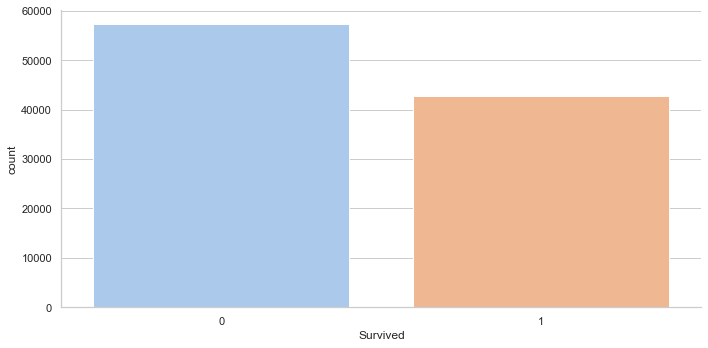

In [54]:
sb.catplot(x='Survived', data=syntanic_data, kind='count', height=5, aspect=2)

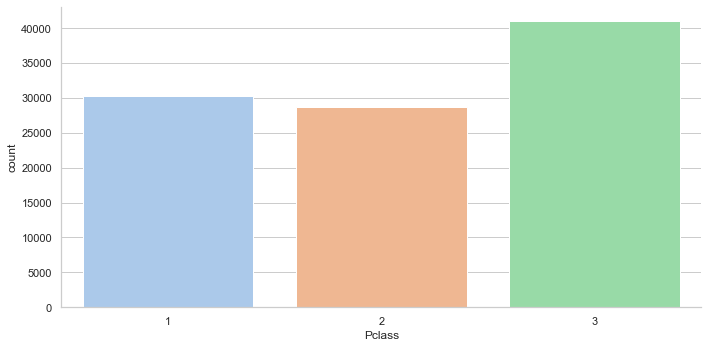

In [55]:
sb.catplot(x='Pclass', data=syntanic_data, kind='count', height=5, aspect=2)

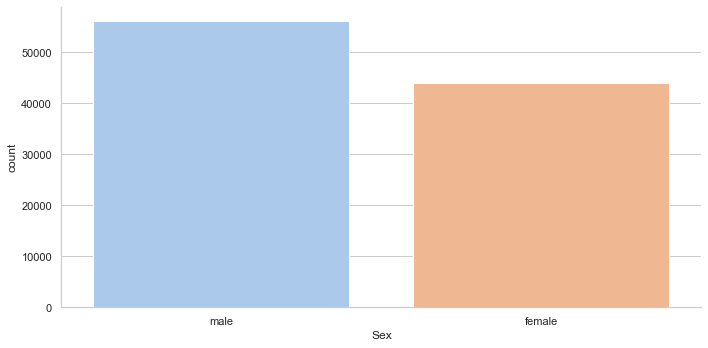

In [56]:
sb.catplot(x='Sex', data=syntanic_data, kind='count', height=5, aspect=2)

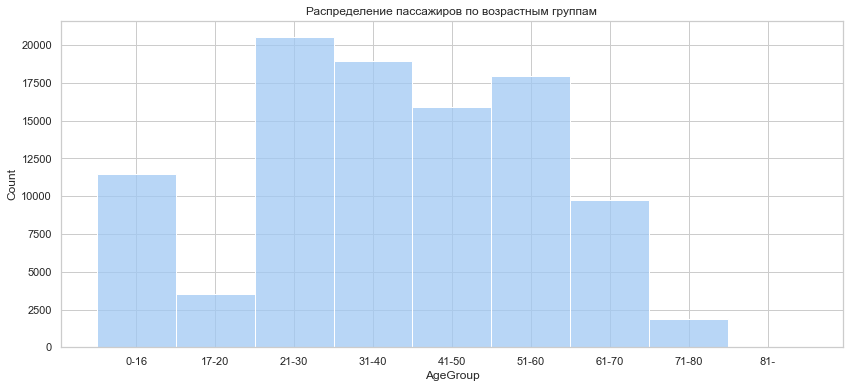

In [74]:
plt.figure(figsize=(14, 6))
plt.title('Распределение пассажиров по возрастным группам')

agegr_count_fig: plt.Axes = sb.histplot(
      data=syntanic_data['AgeGroup'].sort_values())

plt.show()

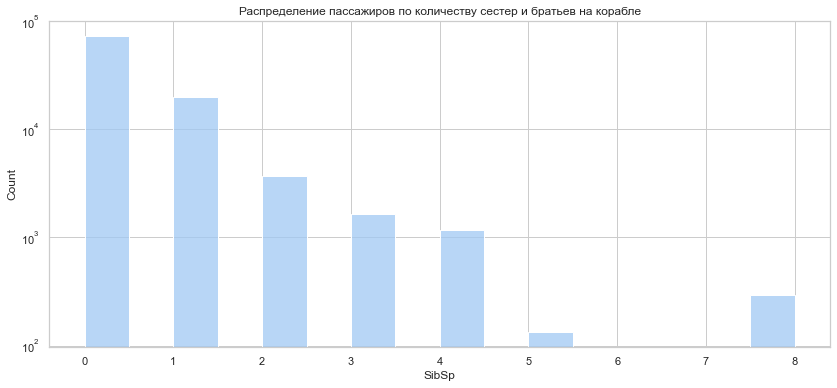

In [89]:
plt.figure(figsize=(14, 6))
plt.title('Распределение пассажиров по количеству сестер и братьев на корабле')

sibsp_count_fig: plt.Axes = sb.histplot(
      data=syntanic_data['SibSp'], binwidth=0.5)
sibsp_count_fig.set_yscale('log')

plt.show()

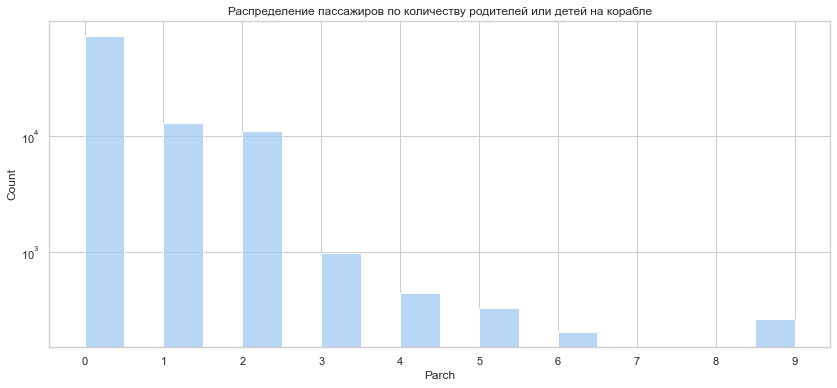

In [93]:
plt.figure(figsize=(14, 6))
plt.title('Распределение пассажиров по количеству родителей или детей на корабле')

parch_count_fig: plt.Axes = sb.histplot(
      data=syntanic_data['Parch'], binwidth=0.5)
parch_count_fig.set_yscale('log')
parch_count_fig.set_xticks(range(10))

plt.show()

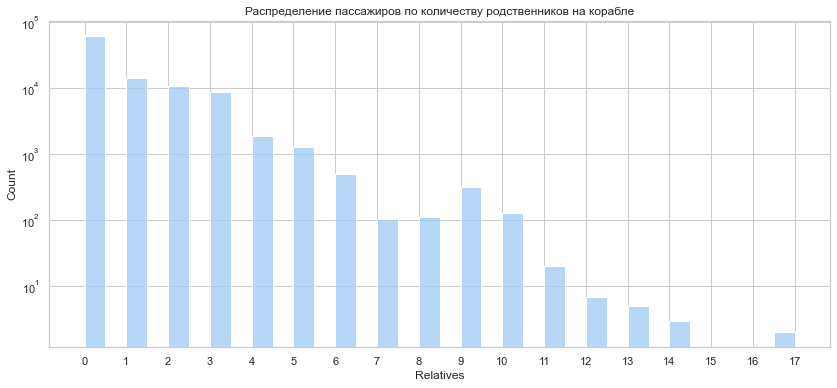

In [95]:
plt.figure(figsize=(14, 6))
plt.title('Распределение пассажиров по количеству родственников на корабле')

rels_count_fig: plt.Axes = sb.histplot(
      data=syntanic_data['Relatives'], binwidth=0.5)
rels_count_fig.set_yscale('log')
rels_count_fig.set_xticks(range(18))

plt.show()

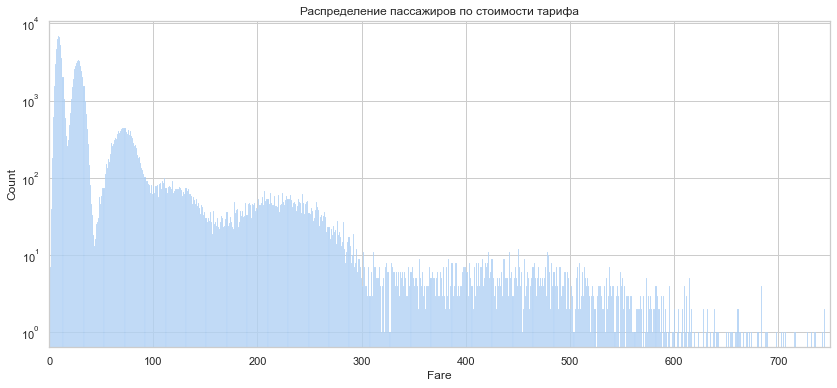

In [103]:
plt.figure(figsize=(14, 6))
plt.title('Распределение пассажиров по стоимости тарифа')

fare_count_fig: plt.Axes = sb.histplot(data=syntanic_data['Fare'])
fare_count_fig.set_yscale('log')
fare_count_fig.set_xlim(0, 750)

plt.show()

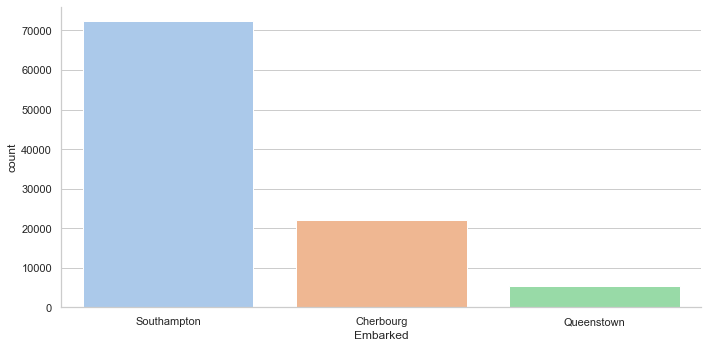

In [104]:
sb.catplot(x='Embarked', data=syntanic_data, kind='count', height=5, aspect=2)

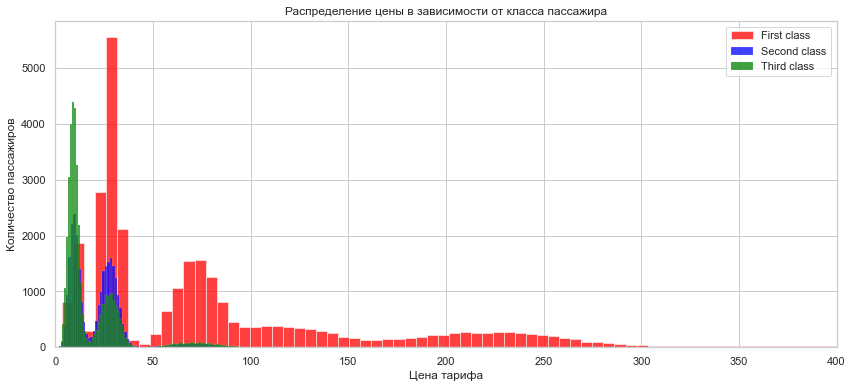

In [58]:
plt.figure(figsize=(14, 6))
plt.title('Распределение цены в зависимости от класса пассажира')

class_price_fig: plt.Axes = sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 1]['Fare'], label='First class',
      color='Red'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 2]['Fare'], label='Second class',
      color='Blue'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 3]['Fare'], label='Third class',
      color='Green'
)

class_price_fig.set(xlabel='Цена тарифа', ylabel='Количество пассажиров')
class_price_fig.set_xlim(0, 400)
plt.legend()
plt.show()

Самая частая стоимость тарифа среди пассажиров 1 класса около 29,2 класса - около 28, 3 класса - 9,5. На гистограмме имеется три ярковыраженных пика для всех трех классов, что скорее всего зависит от порта назначения

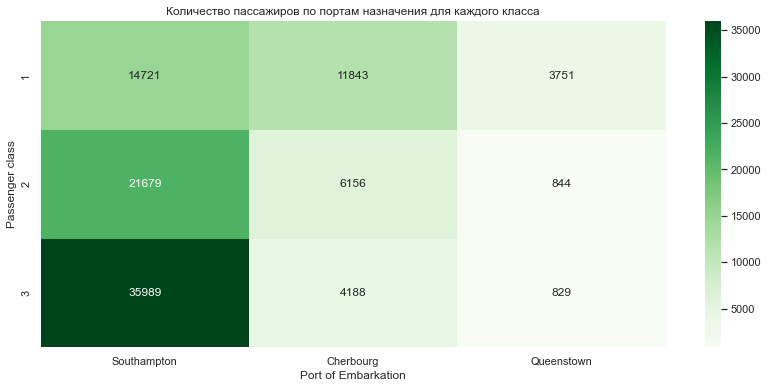

In [59]:
plt.figure(figsize=(14, 6))
plt.title('Количество пассажиров по портам назначения для каждого класса')

class_emdraked_count_data = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.uint32
)
class_emdraked_count_data.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_count_data:
      for row_index in class_emdraked_count_data[column_name].index:
          class_emdraked_count_data[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)].shape[0]

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_count_data, annot=True, fmt='.0f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

Из рисунка видно, что большинство пассажиров всех классов плывет в порт назначения Southampton

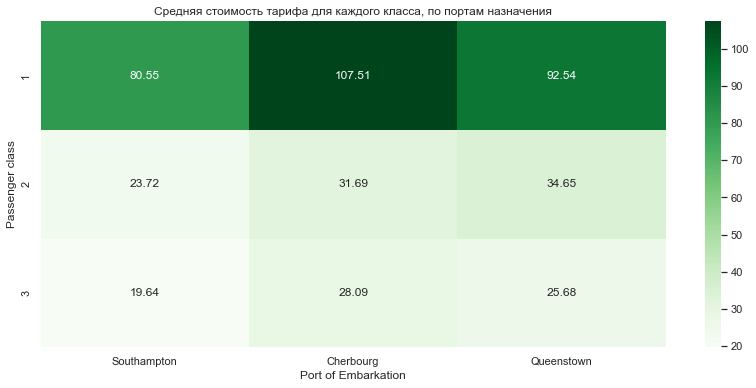

In [60]:
class_emdraked_fare_data_mean = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_mean.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_mean:
      for row_index in class_emdraked_fare_data_mean[column_name].index:
          class_emdraked_fare_data_mean[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].mean()

class_emdraked_fare_data_median = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_median.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_median:
      for row_index in class_emdraked_fare_data_median[column_name].index:
          class_emdraked_fare_data_median[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].median()

plt.figure(figsize=(14, 6))
plt.title('Средняя стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_fare_data_mean, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

Как видно на рисунке наибольшая средняя стоимость у первого класса, при этом наибольшая средняя стоимость наблюдается для порта назначения Cherbourg (кроме 2 класса)

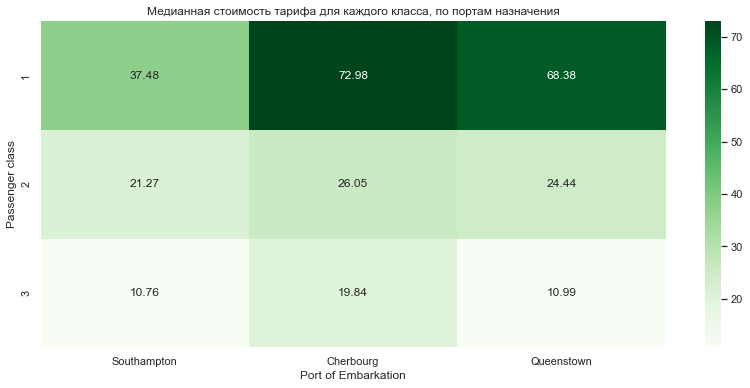

In [61]:
plt.figure(figsize=(14, 6))
plt.title('Медианная стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_median = sb.heatmap(
      data=class_emdraked_fare_data_median, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_median.set_xlabel('Port of Embarkation')
plt.show()

При рассмотрении медианной стоимости наблюдаются отличия. В этом случае более явно видна большая стоимость тарифа до порта назначения Cherbourg. Если сделать логичное предположение, что стоимость зависит от пути, то можно сделать вывод, что путь до Cherbourg наибольший

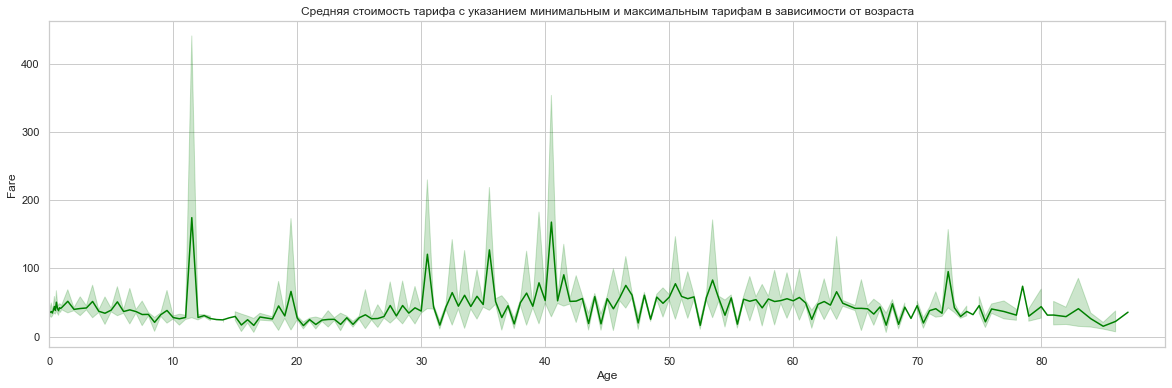

In [62]:
plt.figure(figsize=(20, 6))
plt.title('Средняя стоимость тарифа с указанием минимальным '
          'и максимальным тарифам в зависимости от возраста')

age_fare_fig = sb.lineplot(
      x='Age', y='Fare',
      data=syntanic_data[['Fare', 'Age']].dropna(),
      color='Green')
age_fare_fig.set_xticks(list(range(0, 90, 10)), labels=list(range(0, 90, 10)))
age_fare_fig.set_xlim(0, 90)
plt.show()

Из представленного выше графика можно сделать вывод, что пассажиры в возрасте от 30 до 55 являются самыми платежеспособными гражданами. При этом наблюдаются пики тарифа для восрастов около 41 и 12 лет.

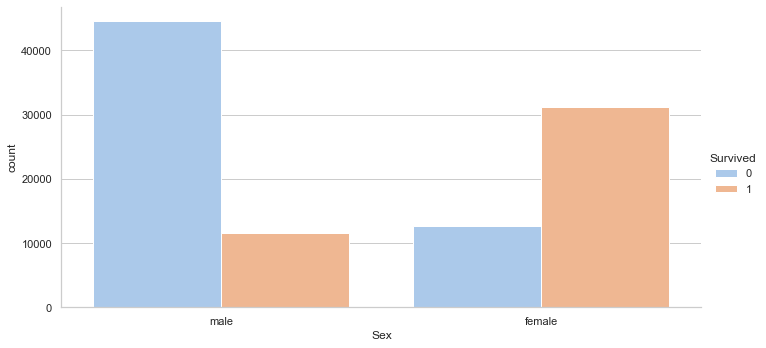

In [63]:
sb.catplot(x='Sex', data=syntanic_data, hue='Survived', kind='count', height=5, aspect=2)

Из рисунка можно сделать вывод, что у женщины выжить шанс больше

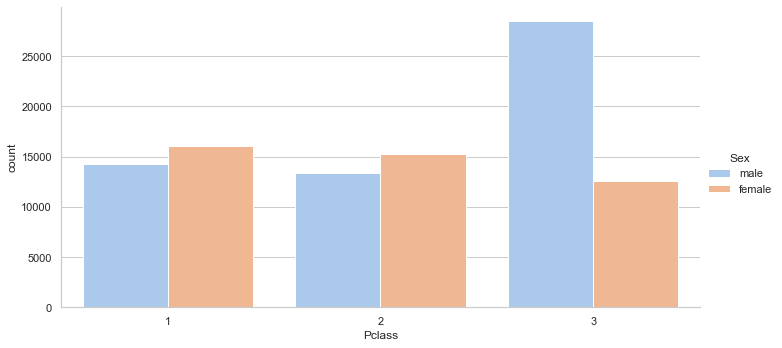

In [64]:
sb.catplot(x='Pclass', data=syntanic_data, hue='Sex', kind='count', height=5, aspect=2)

Количество мужчин и женщин в каждом из классов показывает, что в 3 класса больше всего мужчин, когда в остальных примерно равное отношение

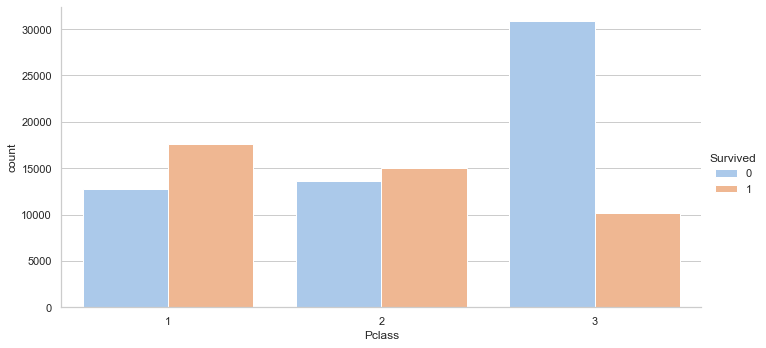

In [65]:
sb.catplot(x='Pclass', data=syntanic_data, hue='Survived', kind='count', height=5, aspect=2)

Количество выживших и погибших в зависимости от класса пассажира указывает на то, что у пассажиров 1 класса больше шансов выжить, чем у пассажира 3 класса

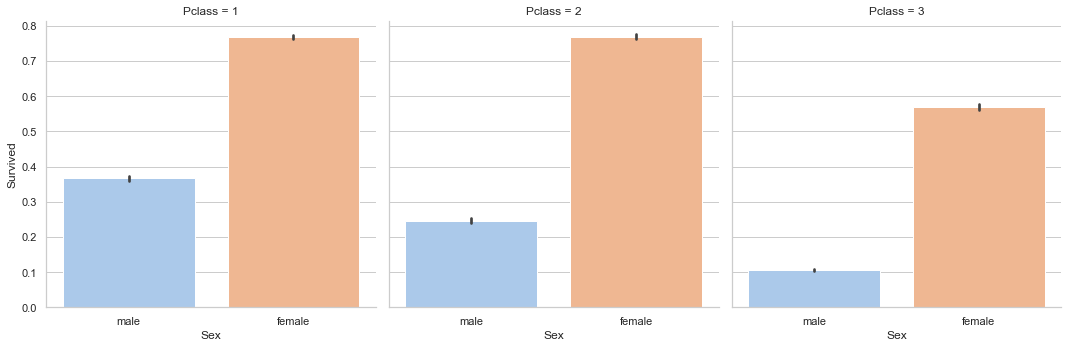

In [66]:
sb.catplot(x='Sex', y='Survived', col='Pclass', data=syntanic_data, kind='bar')

Отношение выживших мужчин и женщин в каждом из классов указывает, что в целом у женщин шанс выживания больше, чем у мужчин, однако у пассажиров 1 класса шанс выживания больше (как у мужчин, так и у женщин)

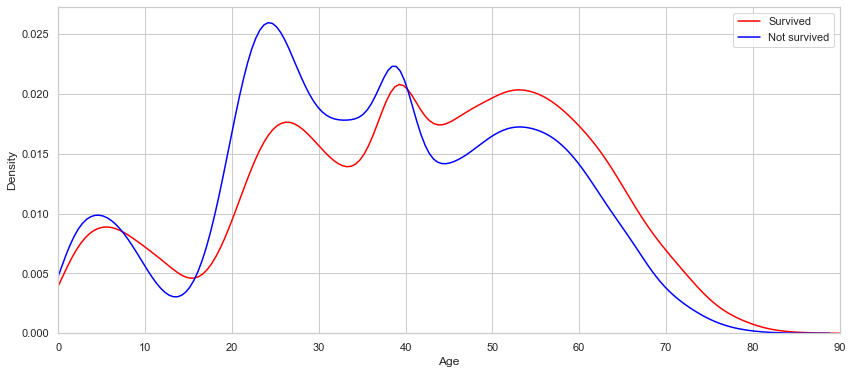

In [67]:
plt.figure(figsize=(14, 6))


ax = sb.kdeplot(
      data=syntanic_data[syntanic_data['Survived'] == 1]['Age'], label='Survived',
      color='Red'
)
sb.kdeplot(
      data=syntanic_data[syntanic_data['Survived'] == 0]['Age'], label='Not survived',
      color='Blue'
)
ax.set_xlim(0, 90)

plt.legend()
plt.show()

Распределение пассажиров по возрастам (с разделением на выживших и нет) показывает, что количество выживших пассажиров детского (но сознательного возраста) и пассажиров старше 40 лет выжило больше, чем других возрастных групп

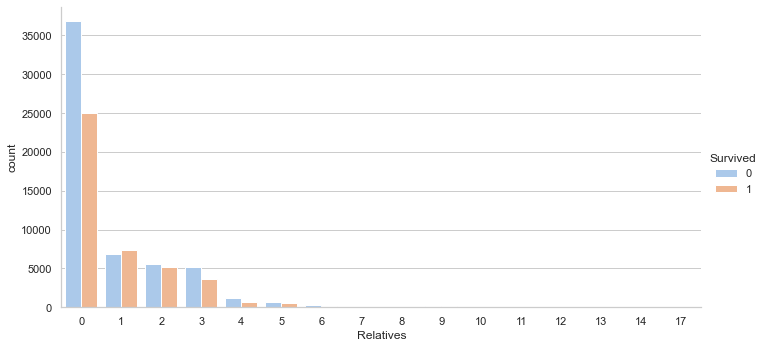

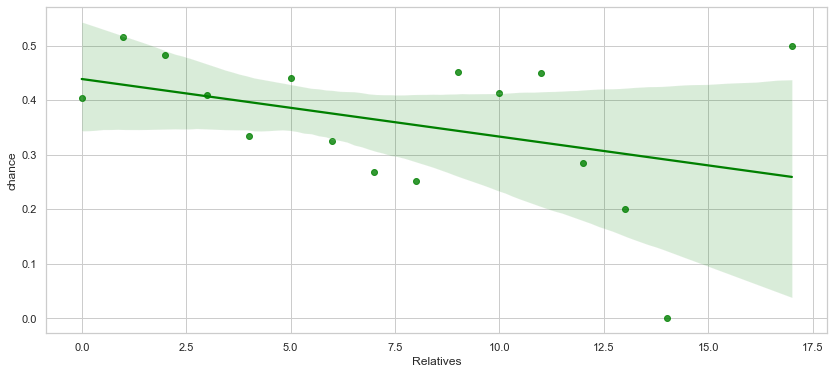

In [68]:
surv_rel_data = pd.DataFrame(columns=['Relatives', 'chance'])

for i in range(syntanic_data['Relatives'].max() + 1):
      relatives_pass_count = syntanic_data[syntanic_data['Relatives'] == i].shape[0]
      relatives_pass_surv_count = syntanic_data[
            (syntanic_data['Relatives'] == i) & (syntanic_data['Survived'] == 1)].shape[0]
      if relatives_pass_count != 0:
            surv_rel_data.loc[i] = i, relatives_pass_surv_count / relatives_pass_count

sb.catplot(x='Relatives', data=syntanic_data,
           hue='Survived', kind='count', height=5, aspect=2)

plt.figure(figsize=(14, 6))
sb.regplot(x=surv_rel_data['Relatives'],
           y=surv_rel_data['chance'],
           color='Green')
plt.show()

Из графиков выше можно сделать вывод, что чем больше родственников на корабле у пассажира, тем меньше его шанс выживания.

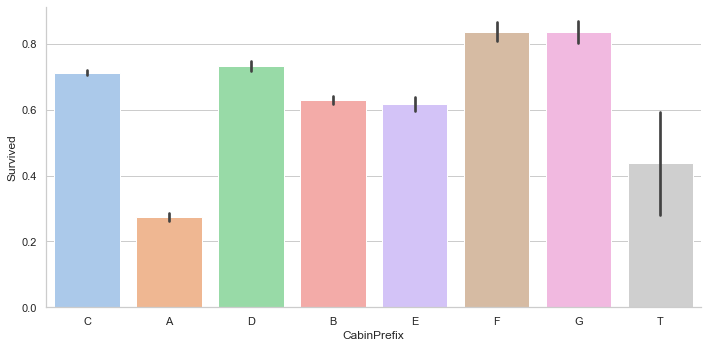

In [69]:
sb.catplot(x='CabinPrefix', y='Survived', data=syntanic_data, kind='bar', height=5, aspect=2)

Если сделать предположение, что первая буква указывает на палубу корабля, то у пассажиров палубы 'A' шанс выживания наименьший, когда у пассажиров палуб 'F', 'G' -- много выше. Тогда можно выдвинуть предположение, что палуба 'A' находится глубже всего в корабле или пробоина Титаника была в области палубы 'A'.

# Summary

При рассмотрении признаков пассажиров с точки зрения выживаемости, можно сделать следующие выводы:
- у женщины шанс выжить более чем в 2 раза больше, когда у мужчин выживаемость -- примерно в 4 раза меньше
- у первого класса пассажиров шанс выжить больше
- У пассажиров в возрасте от 8 до 17 и от 40 выживаемость выше
- наблюдается отрицательная зависимость количества родственников на корабле от шанса выжить
- У пассажиров палубы 'А' выживаемость наименьшая, что частично можно связать с классом пассажиров, так и с деталями катастрофы